In [1]:
import pickle
#import sklearn
#from sklearn import metrics
#from sklearn import linear_model
#import random
#import numpy as np
#from wac import WAC
from tqdm.notebook import tqdm
import pandas as pd
#from sklearn import neural_network
#import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from collections import defaultdict as dd
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/crow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Initiate Datasets

In [2]:
wac2vec = pickle.load(open('ddata/clip.bertvocab.embeddings.513.pkl', 'rb'))
len(wac2vec)

30522

In [3]:
concr_scores = pickle.load(open('ddata/AC_ratings_google3m_koeper_SiW.pkl', 'rb'))
len(concr_scores)

2168990

## ConcreteAbstract Class

In [4]:
class ConcreteAbstract:
    def __init__(self, word_vectors, concr_scores, word_net):
        pass

### Build Abstraction Tree

In [52]:
min_rating = 9
wac_words = list(wac2vec.keys())
wn_words = set(i for i in wn.words())
wn_wac_words = wn_words & set(wac_words)

concr_scores_subset = concr_scores[concr_scores.RATING >= min_rating]

leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]
leaf_synsets = [wn.synsets(w)[0] for w in tqdm(leaf_words)]

  0%|          | 0/14510 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
cocoa

In [55]:
list(zip(leaf_words, leaf_synsets))

[('tomato', Synset('tomato.n.01')),
 ('bandage', Synset('bandage.n.01')),
 ('cereal', Synset('cereal.n.01')),
 ('pig', Synset('hog.n.03')),
 ('beetle', Synset('beetle.n.01')),
 ('lid', Synset('eyelid.n.01')),
 ('bracelet', Synset('watchband.n.01')),
 ('bra', Synset('brassiere.n.01')),
 ('gorilla', Synset('gorilla.n.01')),
 ('pizza', Synset('pizza.n.01')),
 ('shoe', Synset('shoe.n.01')),
 ('sausage', Synset('sausage.n.01')),
 ('crocodile', Synset('crocodile.n.01')),
 ('chocolate', Synset('cocoa.n.01')),
 ('frog', Synset('frog.n.01')),
 ('cocoa', Synset('cocoa.n.01')),
 ('rug', Synset('rug.n.01')),
 ('shark', Synset('shark.n.01'))]

In [ ]:
leaf_synsets

In [324]:
def init_abstraction_tree(min_rating=8):

    wac_words = list(wac2vec.keys())
    wn_words = set(i for i in wn.words())
    wn_wac_words = wn_words & set(wac_words)
    
    concr_scores_subset = concr_scores[concr_scores.RATING >= min_rating]

    leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]

    # Get Leaf Synsets...
    leaf_synsets = [wn.synsets(w)[0] for w in tqdm(leaf_words)]

    # Initiate Abstraction Tree
    embeddings = [wac2vec[w] for w in tqdm(leaf_words)]
    data = {
        "SYNSET" : leaf_synsets,
        "WORD" : leaf_words,
        "DIST2LEAF": [0]*len(leaf_synsets),
        "NUM_LEAVES": [1]*len(leaf_synsets),
        "HYPERNYM": [[]]*len(leaf_synsets),
        "HYPONYMS": [[]]*len(leaf_synsets),
        "EMBEDDING" : embeddings
        
    }
    abstraction_tree = pd.DataFrame(data)
    abstraction_tree.index = abstraction_tree.SYNSET

    # Get True Leaf Synsets
    ancestors = set()
    for s in tqdm(leaf_synsets):
        #print(set(s.closure(lambda s: s.hypernyms())))
        ancestors = ancestors.union(set(s.closure(lambda s: s.hypernyms())))

    # Remove leaves that are ansestors of other leaves
    true_leaf_synsets = set(leaf_synsets) - ancestors
    ansestor_leaves = set(leaf_synsets) - true_leaf_synsets
    abstraction_tree.drop(ansestor_leaves, inplace=True)
    
    # Remove leaves that have the same Synset
    abstraction_tree.drop_duplicates(subset='SYNSET', inplace=True)
    
    return abstraction_tree

In [325]:
abstraction_tree = init_abstraction_tree(9)

  0%|          | 0/14510 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('artifact.n.01') at depth 6
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('matter.n.03') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('entity.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):


In [319]:
len(abstraction_tree)

17

In [270]:
# Build abstraction tree

In [328]:
synset_list = list(abstraction_tree['SYNSET'])

for s in synset_list:
    h = s.hypernyms()
    
    if len(h) == 0:
        continue
        
    h = h[0]

    if h not in abstraction_tree.SYNSET:
        synset_list.append(h)
        abstraction_tree.loc[h] = [
            h,    # SYNSET
            None, # WORD
            0,    # DIST2LEAF
            0,    # NUM_LEAVES
            [],   # HYPERNYM
            [],   # HYPONYMS
            None  # EMBEDDING
        ]
    
    # Set DIST2LEAF
    s_dist = abstraction_tree.loc[s, 'DIST2LEAF']
    h_dist = abstraction_tree.loc[h, 'DIST2LEAF']
    #print(s)
    if s_dist >= h_dist:
        abstraction_tree.loc[h, 'DIST2LEAF'] = s_dist + 1
        
    # Set NUM_LEAVES
    s_num_leaves = abstraction_tree.loc[s, 'NUM_LEAVES']
    h_num_leaves = abstraction_tree.loc[h, 'NUM_LEAVES']
    abstraction_tree.loc[h, 'NUM_LEAVES'] = h_num_leaves + s_num_leaves
    
    # Add hypernym to synset
    abstraction_tree.loc[s, 'HYPERNYM'] = [h]
    
    # Add synset to hypernym
    abstraction_tree.loc[h, 'HYPONYMS'].append(s)

In [329]:
abstraction_tree

,SYNSET,WORD,DIST2LEAF,NUM_LEAVES,HYPERNYM,HYPONYMS,EMBEDDING
SYNSET,,,,,,,
Synset('tomato.n.01'),Synset('tomato.n.01'),tomato,0,1,[Synset('solanaceous_vegetable.n.01')],[],"[-0.156617, -0.061644472, 0.08238742, 0.168585..."
Synset('bandage.n.01'),Synset('bandage.n.01'),bandage,0,1,[Synset('dressing.n.04')],[],"[-0.39212647, -0.09895855, -0.19498833, 0.1028..."
Synset('cereal.n.01'),Synset('cereal.n.01'),cereal,0,1,[Synset('grass.n.01')],[],"[-0.12203906, -0.10503117, -0.055202194, 0.165..."
Synset('hog.n.03'),Synset('hog.n.03'),pig,0,1,[Synset('swine.n.01')],[],"[-0.019314175, -0.3430049, 0.027988998, -0.070..."
Synset('beetle.n.01'),Synset('beetle.n.01'),beetle,0,1,[Synset('insect.n.01')],[],"[-0.05565099, -0.01425737, -0.0025513684, -0.1..."
...,...,...,...,...,...,...,...
Synset('physical_entity.n.01'),Synset('physical_entity.n.01'),None,8,8,[Synset('entity.n.01')],"[Synset('matter.n.03'), Synset('object.n.01'),...",None
Synset('living_thing.n.01'),Synset('living_thing.n.01'),None,7,3,[Synset('whole.n.02')],[Synset('organism.n.01')],None
Synset('part.n.03'),Synset('part.n.03'),None,6,1,[Synset('thing.n.12')],[Synset('body_part.n.01')],None


In [378]:
def build_display_tree(df, root_synset, trim_name=-1):
    row = df.loc[root_synset]
    #root_name = row['SYNSET'].name()[:5]
    root_name = row['SYNSET'].lemmas()[0].name()[:trim_name]
    if len(row['HYPONYMS']) == 0:
        return root_name
    
    children = [build_display_tree(df, h, trim_name) for h in row['HYPONYMS']]
    
    return Tree(root_name, children)

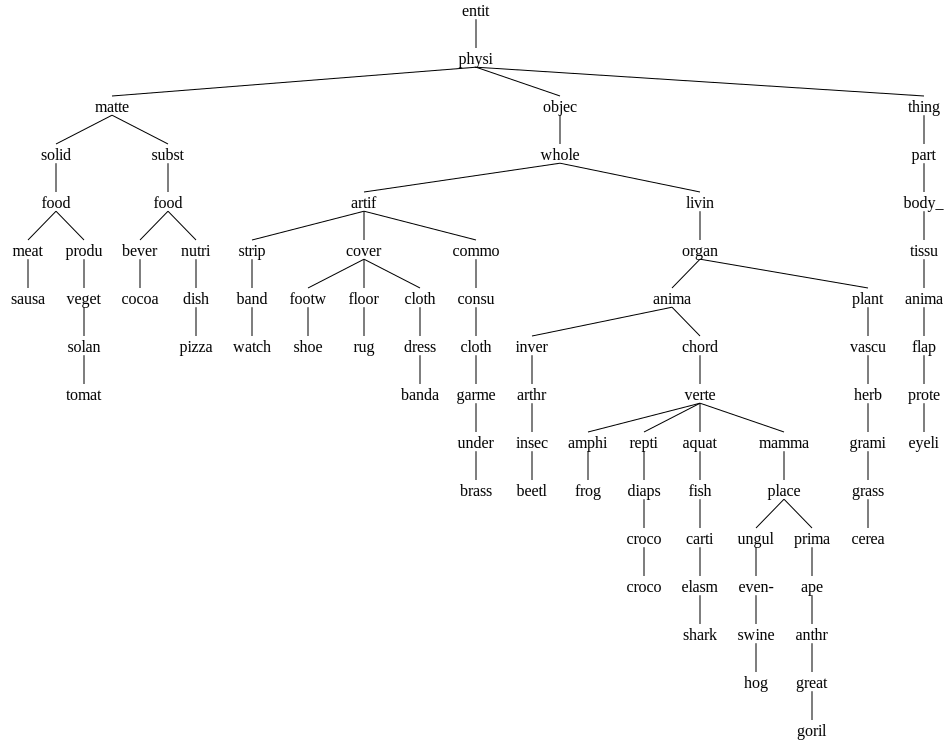

In [381]:
build_display_tree(abstraction_tree, wn.synset('entity.n.01'), trim_name=5)